

$$\zeta(r,z,t) = a_o e^{i \omega_o t} B_0( x, z) +  a_1 e^{i \omega_1 t} B_1(x,z) ...$$

$$
\begin{bmatrix}
d(x_o,z_o,t_o) \\
d(x_o,z_1,t_o) \\
d(x_o,z_2,t_o) \\
\vdots  \\
d(x_N,z_M,t_L) \\
\end{bmatrix}
=
\begin{bmatrix}
\phi_o(z_o) e^{i (k_{o} x_o - \omega_o t_o)  } & 
 \dots & 
 \phi_R(z_o) e^{i (k_{P} x_o - \omega_Q t_o)  }\\ 
 \vdots & \ddots & \\
\phi_o(z_M) e^{i (k_{o} x_N - \omega_o t_L)  } & \dots & 
\phi_R(z_M) e^{i (k_{P} x_N - \omega_Q t_L)  } \\
\end{bmatrix}
\cdot
\begin{bmatrix}
a_{000} \\
a_{100} \\
a_{110} \\
\vdots  \\
a_{P,Q,R} \\
\end{bmatrix}
$$
Where N is the number of parameters and M is the number of data. In general the data and parameters are in multiple dimensions. Multi-dimensional data is flattened into a single vector. 

In [34]:
# Source Libraries
source('src/timeseries_analysis.r')


#Sampling and Noise Params
recordstop <- 200
timesamples <- seq(1,recordstop,2*4)
xsamples <- c(20,25)
zsamples <- c(5,10,15)
ysamples <- xsamples
epsi     <- 1e-3

#Read in Data
path <- '../data/sound_prof_3_inv'
meta <- read_meta(path)

#Ocean profile
stratdf <- read_feather('strat_25.fthr')
strat   <- stratdf$strat
depth   <- seq(0,meta$depth_max,length.out=meta$depth_len)
range   <- seq(0,meta$range_max,length.out=meta$range_len)
    
#Make a initial parameter space
source('../src/inversion.r')
source('../src/modes.r')

#Make parameter space
modes <- seq(1,3,1)
omega <- c(0.0805,0.1)/3600
headings  <- seq(0,90,10)
k <- generate_wavenumbers(depth,strat,omega,modes)

ps <- generate_parameter_space(omega,modes,k,headings) 



In [36]:
#Invert
source('../src/timeseries_analysis.r')
pseudo_invert<-function(ds,ps){
   H <- make_inv_matrix(ds,ps)
   system.time(approx <- tappered_least_square(H,ds$d))
   xl <- length(approx$x_hat)
   ps$a  <- approx$x_hat[1:(xl/2),]
   ps$b  <- approx$x_hat[(xl/2 + 1) :xl,]
   return(ps)
}

subsampling<-function(xsl,ysl){
    pshat <- list()
    for (i in 1:length(xsl) ){
        xsamples <- xsl[[i]]
        ysamples <- ysl[[i]]
        ds      <- read_data_dir(path,epsi,timesamples,xsamples,ysamples,zsamples)
        print(nrow(ds))
        pshat[[i]] <- pseudo_invert(ds,ps)
    }
    return(pshat)
}

dipsampling<-function(center,xsl,ysl){
    pshat <- list()
    for (i in 1:length(xsl) ){
        xsamples <- xsl[[i]]
        ysamples <- ysl[[i]]
        ds      <- read_data_dir(path,epsi,timesamples,xsamples,ysamples,zsamples,center)
        pshat[[i]] <- pseudo_invert(ds,ps)
        print(nrow(ds))
    }
    return(pshat)
}

param_error<-function(pshat){
    rms_a <- c()
    for (pt in pshat) {
        pt <- cbind(atrue=0,pt)
        pt$atrue[pt$heading==0] <- 10
        pt$atrue[pt$heading==60] <- 10
        pt$atrue[pt$heading==90] <- 10
        rms_a <- c(rms_a,mean(sqrt((pt$a-pt$atrue)**2)/10))
    }
    return (rms_a)
}
    
#Subsampling example
N = seq(1,10)

#Line
xsl_lin<-list()
ysl_lin<-list()
for (i in N){
    xsl_lin[[i]] <- c(25-2*i,25-i,25+i,25+2*i)
    ysl_lin[[i]] <- c(25)
}
print('Line subsample')
line_pshat <- subsampling(xsl_lin,ysl_lin)

#Square
xsl_sq<-list()
ysl_sq<-list()
for (i in N){
    xsl_sq[[i]] <- c(25-i,25+i)
    ysl_sq[[i]] <- c(25-i,25+i)
}
print('Square subsample')
square_pshat <- subsampling(xsl_sq,ysl_sq)


#Square Filled
xsl_arr<-list()
ysl_arr<-list()
for (i in N){
    xsl_arr[[i]] <- seq(25-i,25+i)
    ysl_arr[[i]] <- seq(25-i,25+i)
}

print('Array subsample')
array_pshat <- subsampling(xsl_arr,ysl_arr)

#Dipole
xsl_dip<-list()
ysl_dip<-list()
for (i in N){
    xsl_dip[[i]] <- seq(25-i,25+i)
    ysl_dip[[i]] <- seq(25-i,25+i)
}
center <- c(25,25)
print('Dipole subsample')
dip_pshat <- dipsampling(center,xsl_dip,ysl_dip)



[1] "Line subsample"
[1] 300
[1] 300
[1] 300
[1] 300
[1] 300
[1] 300
[1] 300
[1] 300
[1] 300
[1] 300
[1] "Square subsample"
[1] 300
[1] 300
[1] 300
[1] 300
[1] 300
[1] 300
[1] 300
[1] 300
[1] 300
[1] 300
[1] "Array subsample"
[1] 675
[1] 1875
[1] 3675
[1] 6075
[1] 9075
[1] 12675
[1] 16875
[1] 21675
[1] 27075
[1] 33075
[1] "Dipole subsample"
[1] 450
[1] 750
[1] 1050
[1] 1350
[1] 1650
[1] 1950
[1] 2250
[1] 2550
[1] 2850
[1] 3150


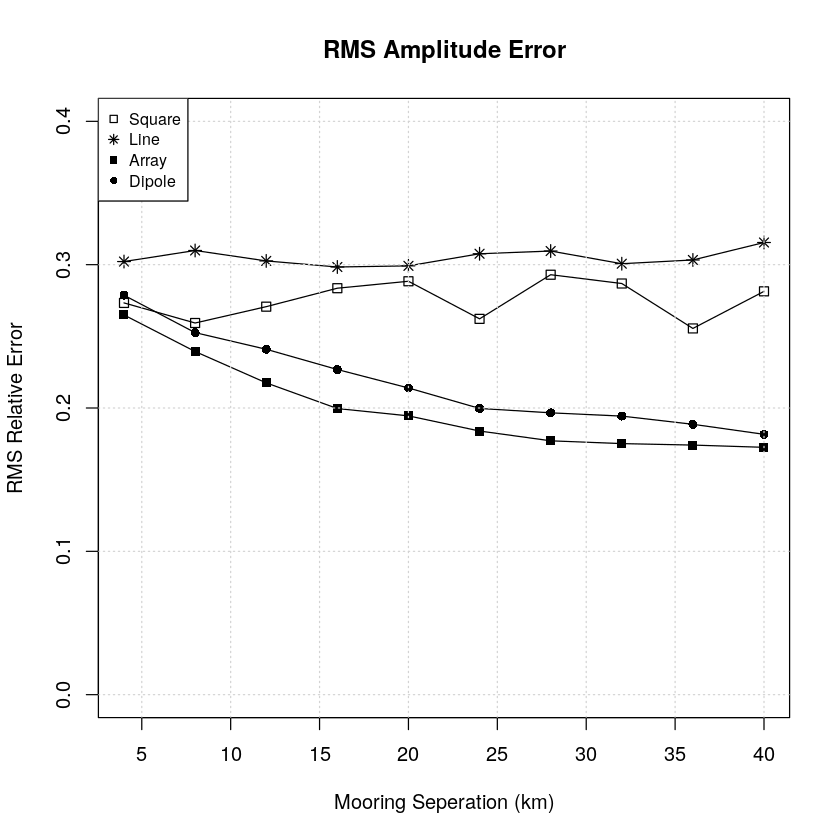

In [37]:
plot(2*N*2,param_error(square_pshat),type='o',main="RMS Amplitude Error",
                ylab="RMS Relative Error",
                xlab="Mooring Seperation (km)",
                ylim=c(0,0.4),pch=0)
points(2*N*2,param_error(line_pshat), type='o',pch=8)
points(2*N*2,param_error(array_pshat),type='o',pch=15)
points(2*N*2,param_error(dip_pshat),type='o',pch=16)

grid()
legend("topleft",legend=c("Square", "Line","Array","Dipole"), pch=c(0,8,15,16),cex=0.8)

In [38]:
png('~/Scripps/Projects/Talks/TFO-Nov-19/mooring_dist_24_hour sample.png')

In [207]:
array_pshat[[1]]$a

[1]  9.727321  9.329310  9.436775 10.326158 10.500149 10.288223 10.718342
[8] 10.665999 10.718437

In [301]:
#Invert
pseudo_invert(ds,ps){
   H <- make_inv_matrix(ds,ps)
   system.time(approx <- tappered_least_square(H,ds$d))
   xl <- length(approx$x_hat)
   ps$a  <- approx$x_hat[1:(xl/2),]
   ps$b  <- approx$x_hat[(xl/2 + 1) :xl,]
   return(ps)
}

   user  system elapsed 
  0.033   0.000   0.033 

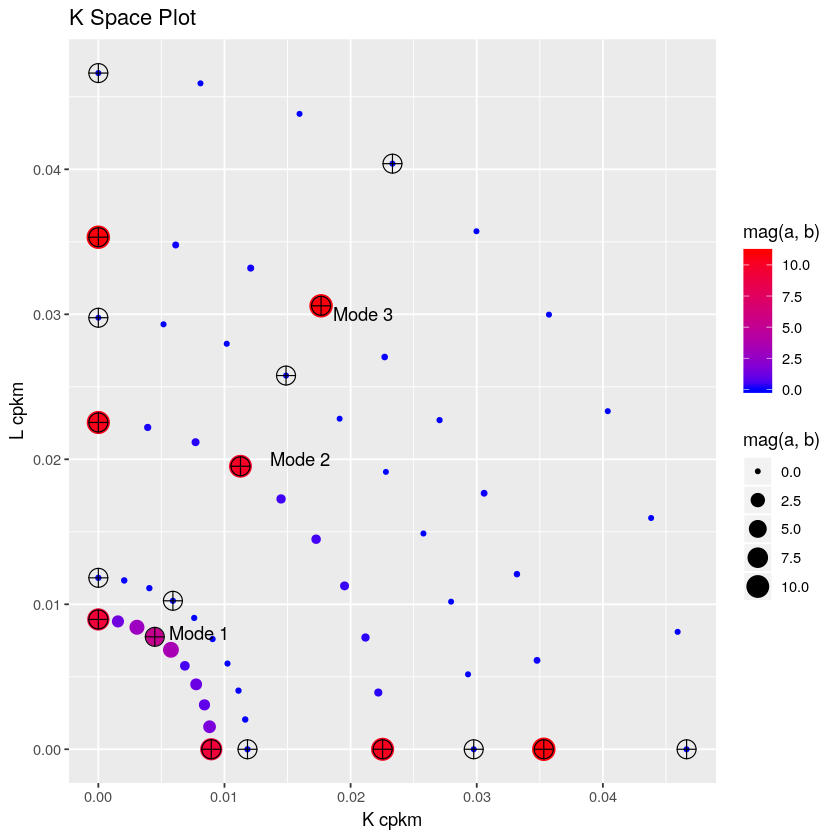

In [52]:
#Plot Square Amplitudes
library(gridExtra)
library(plotly)

mag <- function(a,b){
    return (sqrt(a**2 + b**2))
}

plot_kspace_gg <- function(ps){
    p <- ggplot(ps,aes(x=kx*1000,y=ky*1000,size=mag(a,b),color=mag(a,b))) + 
                geom_point() + 
                scale_color_gradient(low = "blue", high = "red",limits=c(0,11))   
     return (p)
}

plot_kspace_plotly <- function(ps){
     p <- plot_ly( type = 'scatterpolar',mode = 'markers' )
     p <- add_trace(p, 
                     r = ps$k,
                     theta = ps$heading,
                     marker=list(color = 'rgb(231, 99, 250)')
                    )
                  
     return (p)
}

p <- plot_kspace_gg(dip_pshat[[10]]) 
p <-          p+ geom_point(data=ps[ps$heading==60,],aes(x=kx*1000,y=ky*1000),shape=10,size=5,color='black')+
              geom_point(data=ps[ps$heading==0,],aes(x=kx*1000,y=ky*1000),shape=10,size=5,color='black')+
              geom_point(data=ps[ps$heading==90,],aes(x=kx*1000,y=ky*1000),size=5,shape=10,color='black') +
              annotate(geom='text',x=0.008, y=0.008, label="Mode 1") +
              annotate(geom='text',x=0.016, y=0.02, label="Mode 2") +
              annotate(geom='text',x=0.021, y=0.03, label="Mode 3") +
              labs(title='K Space Plot',x='K cpkm',y='L cpkm') +   scale_size(limits = c(0,11))

p

In [55]:
#ggsave('~/Scripps/Projects/Talks/TFO-Nov-19/frat_twin_many_freqs_more_dip.png', plot = p, device='png')


Saving 6.67 x 6.67 in image


In [30]:
#Foward problem
make_forecast <- function(ds_fut,ps){
    a<-c(ps$a,ps$b)
    H2 <- make_inv_matrix(ds_fut,ps)
    ds_fut['d_est'] <- H2%*%a
    return (ds_fut)
}

forecast_error <- function(ds_fut){
    rms_error <- c()
    time <- unique(ds_fut$t)
    for (tt in time ) {
        dt  <- ds_fut$d[ds_fut$t == tt]
        de  <- ds_fut$d_est[ds_fut$t == tt]
        rms_diff <- sqrt(mean( (dt - de)**2  ))
        rms_de   <- sqrt(mean( de**2 ) )
        rms_error <- c(rms_error,rms_diff/rms_de)
    }
    return(rms_error)
}


#Read in the next day
timesamples <- seq(1,400,4)

rms_errors <- list()
#ds_fut    <- rbind(ds,ds_fut)

#Line
ds_fut    <- read_data_dir(path,timesamples,xsl_lin[[1]],ysl_lin[[1]],epsi=epsi)
ds_fut_line    <- make_forecast(ds_fut,line_pshat[[1]]) 
rms_error_line <- forecast_error(ds_fut_line)

#Square
ds_fut    <- read_data_dir(path,timesamples,xsl_sq[[1]],ysl_sq[[1]],epsi=epsi)
ds_fut_sq     <- make_forecast(ds_fut,square_pshat[[1]]) 
rms_error_sq  <- forecast_error(ds_fut_sq)

#Array
ds_fut    <- read_data_dir(path,timesamples,xsl_arr[[1]],ysl_arr[[1]],epsi=epsi)
ds_fut_arr    <- make_forecast(ds_fut,array_pshat[[1]]) 
rms_error_arr <- forecast_error(ds_fut_arr)

#Dipole
ds_fut        <- read_data_dir(path,timesamples,xsl_dip[[1]],ysl_dip[[1]],epsi=epsi,center=center)
ds_fut_arr    <- make_forecast(ds_fut,dip_pshat[[1]]) 
rms_error_dip <- forecast_error(ds_fut_arr)



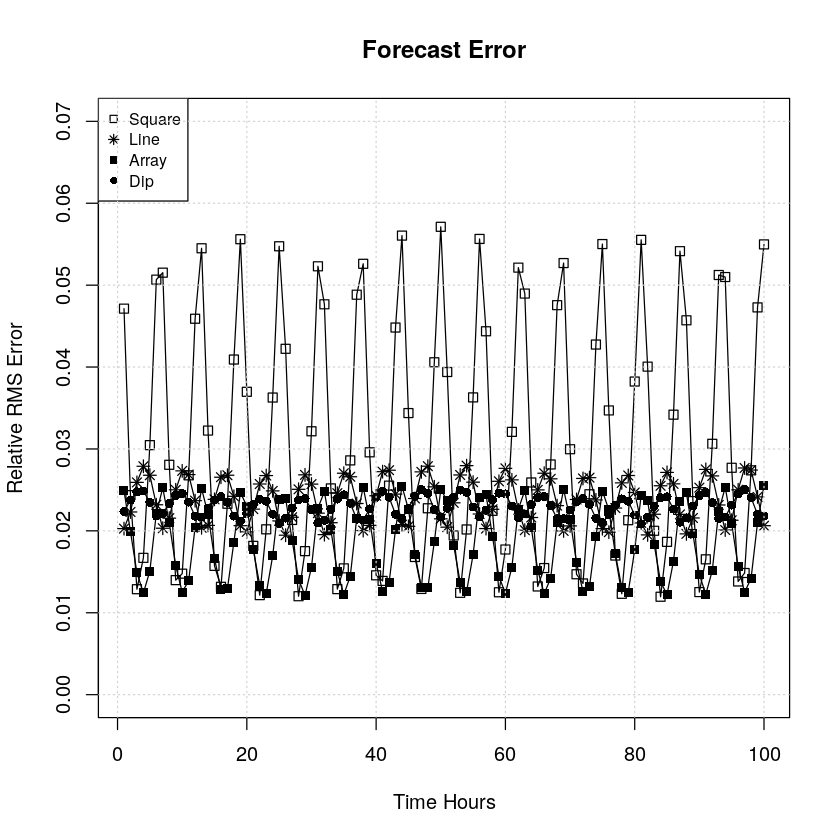

In [33]:
plot(rms_error_line,type='o',pch=8,xlab="Time Hours",ylab="Relative RMS Error",ylim=c(0,0.07))
lines(rms_error_sq,type='o',pch=0,xlab="Time Hours")
lines(rms_error_arr,type='o',pch=15,xlab="Time Hours")
lines(rms_error_dip,type='o',pch=16,xlab="Time Hours")
title('Forecast Error')
legend("topleft",legend=c("Square", "Line","Array",'Dip'), pch=c(0,8,15,16),cex=0.8)
grid()    

In [48]:
#Dipole
ds_fut        <- read_data_dir(path,timesamples,epsi=epsi)
ds_fut_arr    <- make_forecast(ds_fut,dip_pshat[[6]]) 
rms_error_dip <- forecast_error(ds_fut_arr)

In [51]:
 #write_feather(ds_fut_arr,'forecast_dataframe.fthr')

In [108]:
hist(rms_error)

ERROR: Error in hist(rms_error): object 'rms_error' not found
